In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyneb as pn

## Exploring line intensities with the EmisGrid class

### The EmisGrid class

Most plots are obtained by operating on emission maps, which are grids of emissivities as a function of temperature and density generated by the __EmisGrid__ class.

__EmisGrid__ instantiates an atom and computes the emissivities of all its lines for the (tem, den) values of a regularly spaced grid (may be log or linear in the case of the density). Each line is represented in a 2D array (a grid), and there are as many arrays transitions in the atom. The results can be operated on, saved for a later use in a cPickle file, or restored.

The following command instantiates an [O III] atom and computes the emissivity of all its lines in a 30x30 grid:

In [2]:
O3_EG = pn.EmisGrid('O', 3, n_tem=30, n_den=30)

The arguments are described in more details in the Reference Manual. Here is the list:

In [3]:
O3_EG = pn.EmisGrid(elem='O', spec=3, n_tem=100, n_den=100, 
                    tem_min=5000., tem_max=20000., den_min=10., 
                    den_max=1.e8, restore_file=None, atomObj=None)

The emissivity grid of a specific line can be obtained by means of:

In [4]:
O3_5007 = O3_EG.getGrid(wave=5007)

In [5]:
O3_5007.shape

(100, 100)

The emissivity grid of a combination of lines can also be computed:

In [6]:
O3_Te = O3_EG.getGrid(to_eval = 'L(4363)/L(5007)')

There are two plotting tools integrated in the __EmisGrid__ object: 

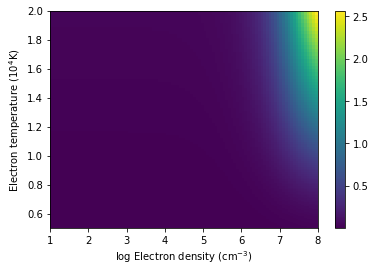

In [7]:
O3_EG.plotImage(to_eval = 'L(4363)/L(5007)')

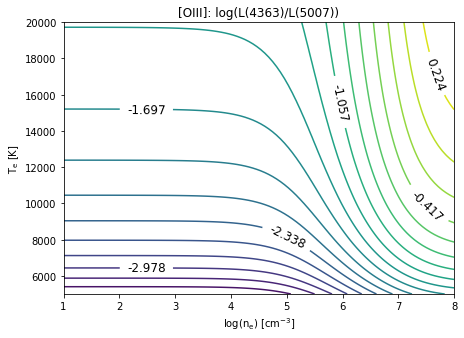

In [8]:
f, ax = plt.subplots(figsize=(7,5))
O3_EG.plotContours(to_eval = 'L(4363)/L(5007)', ax=ax)
f.savefig('OIII_diag.pdf')

See the Reference Manual for more option and the __Diagnostic__ class for producing plots combining different atoms.

### Instantiating various EmisGrid objects with getEmisGridDict

It is quite common to have to instantiate various __EmisGrid__ objects, especially if you want to make a diagnostic diagram. This can easily be done using the __getEmisGridDict__ method, used for example as follows:

In [9]:
emisgrids = pn.getEmisGridDict(atom_list=['O2', 'O3', 'N2'])

warng getEmisGridDict: Wrong emission map: ./pypics//emis_O2.pypic, creating it
warng getEmisGridDict: Wrong emission map: ./pypics//emis_O3.pypic, creating it
warng getEmisGridDict: Wrong emission map: ./pypics//emis_N2.pypic, creating it


In [10]:
emisgrids

{'O2': <pyneb.core.emisGrid.EmisGrid at 0x131c7399d0>,
 'O3': <pyneb.core.emisGrid.EmisGrid at 0x131c712a10>,
 'N2': <pyneb.core.emisGrid.EmisGrid at 0x131c813e50>}

This command generates a dictionary of emission grids for [O II], [O III] and [N II]. The resulting maps are saved in a directory defined by default when PyNeb is started, in the pn.config.pypic_path variable. It first tries to use the $HOME/.pypics directory; if it fails, it tries to use /tmp/pypic; if it fails too, the value is set to None and a user-defined value has to be provided by changing pn.config.pypic_path  or using the pypic_path parameter when calling getEmisGridDict.

If a Diagnostic object is already available (see next Section), it can be used to determine the relevant atoms for which a grid must be computed or restored:

In [11]:
diags = pn.Diagnostics() # See next section
emisgrids = pn.getEmisGridDict(atomDict=diags.atomDict, den_max=1e6)

This __EmisGrid__ dictionary will be very useful to plot diagnostic diagrams with the __Diagnostic__ object, as is described in the next section.

## The Diagnostics class

__Diagnostics__ is the class used to evaluate temperatures and densities from line ratios. It is also the class that plots the diagnostic Te-Ne diagrams. The object is instantiated like this:

In [12]:
diags = pn.Diagnostics()        # instantiate the Diagnostic class  

An optional parameter __addAll=True__ (default is __False__) lets the object load all the available diagnostics. Most of the time this option is not used and the diagnostics are added manually as they are needed:

In [13]:
diags.addDiag(['[NI] 5198/5200','[NII] 5755/6548','[OII] 3726/3729'])

Each diagnostic is defined by a label and is associated to a tuple containing 3 elements: the atom corresponding to the diagnostic lines, the algebraic definition of the line ratios and the algebraic definition of the error of the diagnostic, which depends on the error of each line involved. In the present case, the diagnostic is the ratios of two [O III] lines, 4363/5007, and the error is the quadratic sum of the relative error of each line (E(lambda)): RMS(a, b) = sqrt(a**2 + b**2).

Users can also define their own diagnostics, for example using:

In [14]:
diags.addDiag('[OIII] 4363/4959', ('O3', 'L(4363)/L(4959)', 'RMS([E(4363),E(4959)])'))

Notice that the diagnostics are defined so that they tend to increase with the main parameter they trace: [OIII] 4363/5007 increases with the electron temperature.

The diagnostics contained in a __Diagnostics__ object are listed by means of the __diags.getDiagLabels()__ and __diags.getDiags()__ methods. Once added to the __Diagnostics__ object, they can be used either to compute __Te__ and __Ne__ via __getCrossTemDen__ or to plot diagrams (see below). A diagnostic can be removed from the list with the __delDiag__ method.

### Determination of temperature and density

The __getCrossTemDen__ method cross-converges the temperature and density derived from two sensitive line ratios (not necessarily from the same atom), by inputting the quantity derived with one line ratio into the other and then iterating. When the iteration process ends, the two diagnostics give self-consistent results. The first line ratio must be a temperature-sensitive one and the second a density-sensitive one. The temperature and density can be individual numbers as well as arrays (provided they are equal in shape).

In [15]:
diags.getCrossTemDen('[NII] 5755/6548', '[SII] 6731/6716', 0.02, 1.0)

(7612.554292918343, 444.7122084104995)

In [16]:
for diag in sorted(pn.diags_dict.keys()):
    print('"{0}" : {1}'.format(diag, pn.diags_dict[diag]))

"OII 4649.13/4089.29" : ('O2r', "S('4649.13')/S('4089.29')", "RMS([SE('4649.13'), SE('4089.29')])")
"OII 4649.13/4661.63" : ('O2r', "S('4649.13')/S('4661.63')", "RMS([SE('4649.13'), SE('4661.63')])")
"[ArIII] (7751+7136)/9m" : ('Ar3', '(L(7751)+L(7136))/L(90000)', 'RMS([E(90000), E(7751)*L(7751)/(L(7751)+L(7136)), E(7136)*L(7136)/(L(7751)+L(7136))])')
"[ArIII] 5192/7136" : ('Ar3', 'L(5192)/L(7136)', 'RMS([E(7136), E(5192)])')
"[ArIII] 5192/7300+" : ('Ar3', 'L(5192)/(L(7751)+L(7136))', 'RMS([E(7751)*L(7751)/(L(7751)+L(7136)), E(7136)*L(7136)/(L(7751)+L(7136)), E(5192)])')
"[ArIII] 7136/9m" : ('Ar3', 'L(7136)/L(90000)', 'RMS([E(90000), E(7136)])')
"[ArIII] 9.0m/21.8m" : ('Ar3', 'L(89897)/L(218000)', 'RMS([E(89897), E(218000)])')
"[ArIV] 2860+/4720+" : ('Ar4', '(L(2854)+L(2868))/(L(4711)+L(4740))', 'RMS([E(4711)*L(4711)/(L(4711)+L(4740)), E(4740)*L(4740)/(L(4711)+L(4740)), E(2854)*L(2854)/(L(2854)+L(2868)), E(2868)*L(2854)/(L(2854)+L(2868))])')
"[ArIV] 4740/4711" : ('Ar4', 'L(4740)/L(4711

### Diagnostic diagram combining various atoms

The plotting tool included in the __Diagnostics__ class requires an __EmisGrid__ dictionary (as returned by __pn.getEmisGridDict__; see the previous section) and an __Observation__ object. The plot is obtained by:

In [17]:
obs = pn.Observation()
obs.readData('observations1.dat', fileFormat='lines_in_rows', err_default=0.05) # fill obs with data read from observations1.dat
obs.def_EBV(label1="H1r_6563A", label2="H1r_4861A", r_theo=2.85)
obs.correctData(normWave=4861.)

In [18]:
diags = pn.Diagnostics()
diags.addDiagsFromObs(obs)
diags.diags

warng Observation: No line for O2_3727A+ from NoneNone at wavelength None (blend=False)


{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 '[OII] 3726/3729': ('O2', 'L(3726)/L(3729)', 'RMS([E(3729), E(3726)])'),
 '[OII] 3727+/7325+': ('O2',
  '(L(3726)+L(3729))/(B("7319A+")+B("7330A+"))',
  'RMS([E(3726)*L(3726)/(L(3726)+L(3729)), E(3729)*L(3729)/(L(3726)+L(3729)),BE("7319A+")*B("7319A+")/(B("7319A+")+B("7330A+")),BE("7330A+")*B("7330A+")/(B("7319A+")+B("7330A+"))])'),
 '[OIII] 4363/5007': ('O3', 'L(4363)/L(5007)', 'RMS([E(5007), E(4363)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SII] 4069/4076': ('S2', 'L(4069)/L(4076)', 'RMS([E(4069), E(4076)])'),
 '[SII] 4072+/6720+': ('S2',
  '(L(4069)+L(4076))/(L(6716)+L(6731))',
  'RMS([E(6716)*L(6716)/(L(6716)+L(6731)), E(6731)*L(6731)/(L(6716)+L(673

In [19]:
obs.getIntens()

{'S4_10.5m': array([4.07647872]),
 'Ne2_12.8m': array([4.82602971]),
 'Ne3_15.6m': array([19.80270223]),
 'S3_18.7m': array([5.80184591]),
 'O2_3726A': array([46.57643989]),
 'O2_3729A': array([21.812058]),
 'Ne3_3869A': array([21.72186216]),
 'Ne3_3968A': array([7.25498471]),
 'S2_4069A': array([0.95040452]),
 'S2_4076A': array([0.50268123]),
 'O3_4363A': array([4.68705107]),
 'H1r_4861A': array([100.]),
 'O3_5007A': array([425.5991546]),
 'N2_5755A': array([0.45384655]),
 'S3_6312A': array([0.64146101]),
 'O1_6300A': array([1.42792388]),
 'O1_6364A': array([0.45369748]),
 'N2_6548A': array([5.65746807]),
 'H1r_6563A': array([285.]),
 'N2_6584A': array([15.66847485]),
 'S2_6716A': array([0.99540541]),
 'S2_6731A': array([1.77656379]),
 'Ar3_7136A': array([3.88214979]),
 'O2_7319A+': array([5.10642446]),
 'O2_7330A+': array([4.03377032])}

warng getEmisGridDict: Wrong emission map: ./pypics//emis_S2.pypic, creating it
warng getEmisGridDict: Wrong emission map: ./pypics//emis_S3.pypic, creating it
warng getEmisGridDict: Wrong emission map: ./pypics//emis_Ne3.pypic, creating it


/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:600: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(X, Y, diag_map, levels=[diag_value], colors=col, linestyles=style)


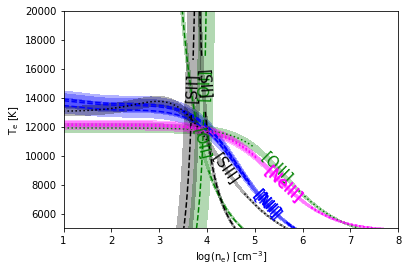

In [20]:
import matplotlib as mpl
%config InlineBackend.figure_format = 'png'
mpl.rc("savefig", dpi=150)
emisgrids = pn.getEmisGridDict(atomDict=diags.atomDict)
diags.plot(emisgrids, obs)

If there is more than one spectrum in the __Observation__ object, the index of the observation to be used is given by __i_obs__:

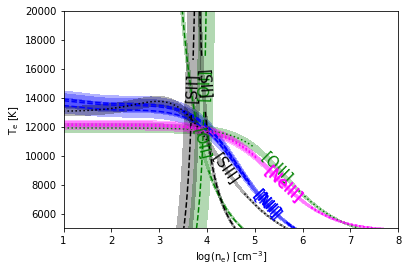

In [21]:
diags.plot(emisgrids, obs, i_obs = 0)

In [22]:
diags.diags

{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 '[OII] 3726/3729': ('O2', 'L(3726)/L(3729)', 'RMS([E(3729), E(3726)])'),
 '[OII] 3727+/7325+': ('O2',
  '(L(3726)+L(3729))/(B("7319A+")+B("7330A+"))',
  'RMS([E(3726)*L(3726)/(L(3726)+L(3729)), E(3729)*L(3729)/(L(3726)+L(3729)),BE("7319A+")*B("7319A+")/(B("7319A+")+B("7330A+")),BE("7330A+")*B("7330A+")/(B("7319A+")+B("7330A+"))])'),
 '[OIII] 4363/5007': ('O3', 'L(4363)/L(5007)', 'RMS([E(5007), E(4363)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SII] 4069/4076': ('S2', 'L(4069)/L(4076)', 'RMS([E(4069), E(4076)])'),
 '[SII] 4072+/6720+': ('S2',
  '(L(4069)+L(4076))/(L(6716)+L(6731))',
  'RMS([E(6716)*L(6716)/(L(6716)+L(6731)), E(6731)*L(6731)/(L(6716)+L(673

The label used to identify emission lines can be changed in the __diags__ object, using for example:

In [23]:
diags.addClabel('[OIII] 4363/5007', '[OIII]na')

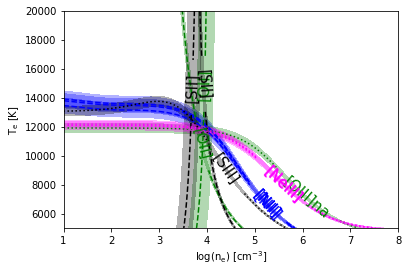

In [24]:
diags.plot(emisgrids, obs, i_obs = 0)